In [ ]:
!pip install keras==2.4.3

In [ ]:
!pip install tensorflow==2.4.1

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

In [1]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import (Dense, Dropout, GlobalMaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras import optimizers
import tensorflow as tf
import numpy as np
import keras
import time
import random
import json


In [3]:
print("starting")

if __name__ == '__main__':
    start = time.time()
    random.seed(8675309)
    #model = VGG16()
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       rotation_range=5,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       # zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        "/content/archive/train/",
        target_size=(48, 48),
        subset='training',
        batch_size=64,
        class_mode='categorical'
    )
    val_gen = val_datagen.flow_from_directory(
        "/content/archive/train/",
        target_size=(48, 48),
        subset='validation',
        batch_size=64,
        class_mode='categorical'
    )
    test_gen = test_datagen.flow_from_directory(
        "/content/archive/test/",
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical'
    )

    # pre-process the data for Keras
    vgg_model = VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape=(48, 48, 3))

    for layer in vgg_model.layers[:20]:
        layer.trainable = False

    # I'll retrain the network from 20th layer
    for layer in vgg_model.layers[20:]:
        layer.trainable = True

    layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

    # Getting output tensor of the last VGG layer that we want to include
    x = layer_dict['block5_pool'].output

    x = GlobalMaxPooling2D()(x)

    x = Dense(512, activation='relu')(x)

    x = Dropout(0.5)(x)

    x = Dense(7, activation='softmax')(x)

    model = Model(vgg_model.input, x)

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

    # from keras import optimizers
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=METRICS)
    model.summary()

    jsonmodel = model.to_json()
    with open('expression.json', 'w') as fp:
        json.dump(jsonmodel, fp)

    epochs = 50
    batch_size = 64

    lrd = ReduceLROnPlateau(monitor='val_loss', patience=10,
                            verbose=1, factor=0.50, min_lr=1e-10)

    es = EarlyStopping(verbose=1, patience=10)

    checkpointer = ModelCheckpoint(filepath='expression.hdf5',
                                   verbose=1)

    history = model.fit_generator(train_gen, epochs=epochs, callbacks=[lrd, checkpointer, es],
                                  verbose=1, validation_data=val_gen, validation_steps=5741//batch_size,
                                  steps_per_epoch=22968//batch_size)

    print(history.history.keys())
    
    end = time.time()
    print(end - start)


starting
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
358/358 [==============================] - 62s 167ms/step - loss: 1.8941 - accuracy: 0.8547 - precision: 0.2695 - recall: 0.0095 - auc: 0.6321 - val_loss: 1.7130 - val_accuracy: 0.8579 - val_precision: 0.5779 - val_recall: 0.0202 - val_auc: 0.7134

Epoch 00001: saving model to expression.hdf5
Epoch 2/50
358/358 [==============================] - 40s 111ms/step - loss: 1.7384 - accuracy: 0.8572 - precision: 0.5036 - recall: 0.0147 - auc: 0.7013 - val_loss: 1.6802 - val_accuracy: 0.8585 - val_precision: 0.5993 - val_recall: 0.0297 - val_auc: 0.7273

Epoch 00002: saving model to expression.hdf5
Epoch 3/50
358/358 [==============================] - 41s 113ms/step - loss: 1.7101 - accuracy: 0.8578 - precision: 0.5574 - recall: 0.0207 - auc: 0.7153 - val_loss: 1.6618 - val_accuracy: 0.8588 - val_precision: 0.6120 - val_recall: 0.0321 - val_auc: 0.7358

Epoch 00003: saving model to expression.hdf5
Epoch 4/50
358/358 [==============================] - 40s 111ms/step - loss: 1.6926 -

KeyError: ignored

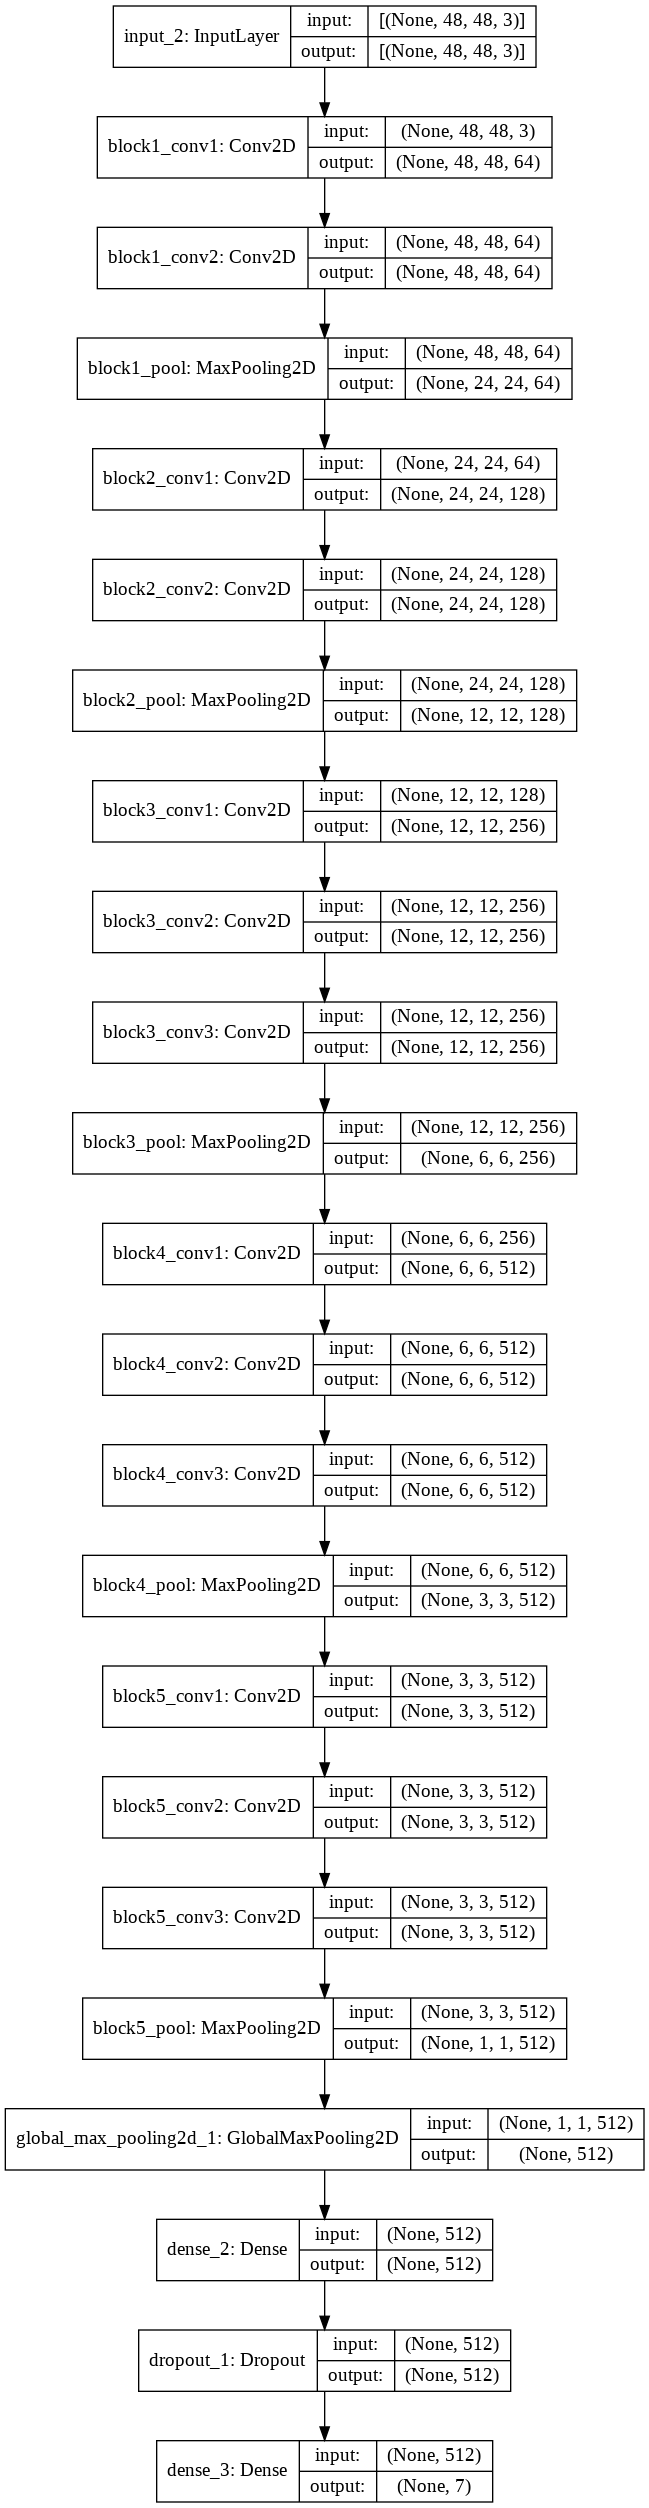

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

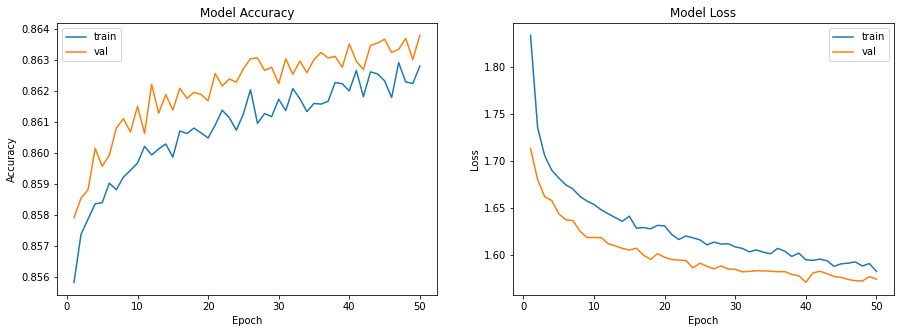

In [4]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

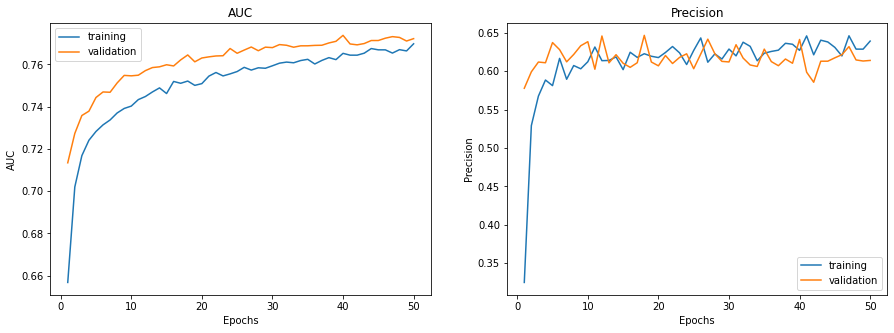

In [5]:
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(range(1, len(auc) + 1), auc)
ax1.plot(range(1, len(val_auc) + 1), val_auc)
ax1.set_title('AUC')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUC')
ax1.legend(['training', 'validation'])

ax2.plot(range(1, len(precision) + 1), precision)
ax2.plot(range(1, len(val_precision) + 1), val_precision)
ax2.set_title('Precision')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend(['training', 'validation'])

In [7]:
expression_dict = list(train_gen.class_indices.keys())
expression_dict

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

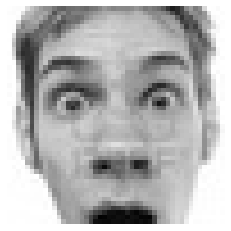

surprise
[[0.04066521 0.00959218 0.11425567 0.1964749  0.13485157 0.07396973
  0.43019077]]


In [8]:
from keras.preprocessing import image

def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(48,48))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


# loaded_model = load_model("model_vgg16.h5")

img_path = '/content/archive/test/surprise/PublicTest_53542593.jpg'

new_image = load_image(img_path)

pred = model.predict(new_image)

predictions = list(pred[0])
expression_output = expression_dict[(predictions.index(max(predictions)))]

print(expression_output)
print(pred)